In [22]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST

## Torch

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution_with_validation.ipynb

In [118]:
import torch

num_workers = 0  # number of subprocesses to use for data loading
batch_size = 64  # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation
imgsize = 28
epochs = 50
patience = 2

### Load Data

In [119]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

# build train/val indices
numtrain = len(train_data)
indices = list(range(numtrain))
np.random.shuffle(indices)
split = int(valid_size * numtrain)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

print(numtrain)

60000


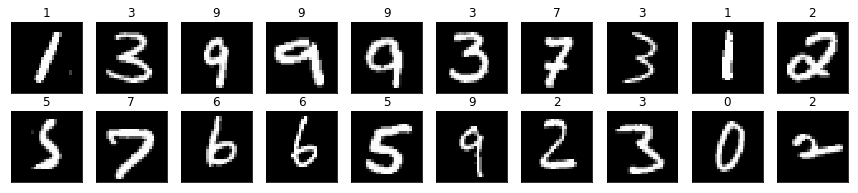

In [120]:
#visualize
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### Model

In [121]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(imgsize*imgsize, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = x.view(-1, imgsize*imgsize)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [122]:
criterion = nn.CrossEntropyLoss()  # Linear output with CrossEntropyLoss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print(model(images).shape)

### Train

In [123]:
valid_loss_min = np.Inf            # best loss so far
epochs_without_improvement = 0
import tempfile                    # tempfile for saving model
_,weightsfile=tempfile.mkstemp()

for epoch in range(epochs):
    train_loss = valid_loss = 0.
    
    # train
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.sampler)
        
    # validation
    model.eval() 
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)        
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print(f'Epoch {epoch+1}: \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
#         print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), weightsfile)
        valid_loss_min = valid_loss
    else:
        epochs_without_improvement+=1
    if epochs_without_improvement>patience:
        break
        
model.load_state_dict(torch.load(weightsfile))

Epoch: 1 	Training Loss: 2.346165 	Validation Loss: 0.254801
Epoch: 2 	Training Loss: 0.366816 	Validation Loss: 0.239802
Epoch: 3 	Training Loss: 0.320025 	Validation Loss: 0.205405
Epoch: 4 	Training Loss: 0.310983 	Validation Loss: 0.205187
Epoch: 5 	Training Loss: 0.302449 	Validation Loss: 0.200438
Epoch: 6 	Training Loss: 0.291429 	Validation Loss: 0.184569
Epoch: 7 	Training Loss: 0.281133 	Validation Loss: 0.171273
Epoch: 8 	Training Loss: 0.273720 	Validation Loss: 0.184329
Epoch: 9 	Training Loss: 0.275360 	Validation Loss: 0.162601
Epoch: 10 	Training Loss: 0.266861 	Validation Loss: 0.201820
Epoch: 11 	Training Loss: 0.262373 	Validation Loss: 0.188930


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Evaluate

In [124]:
test_loss = 0.0
class_correct = list(0. for i in range(10))  # number of correctly labeled data in each class
class_total = list(0. for i in range(10))    # number of data in each class

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    prob, pred = torch.max(output, 1)  # along the 2nd axis
    correct = pred.eq(target)
    
    for i in range(len(target)):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {i}: {100*class_correct[i]/class_total[i]:.2f}% ({np.sum(class_correct[i])}/{np.sum(class_total[i]):.2f})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f'Test Accuracy (Overall): {100.*np.sum(class_correct)/np.sum(class_total):.2f}% ({np.sum(class_correct)}/{np.sum(class_total)})')

Test Loss: 0.195999
Test Accuracy of 0: 97.65% (957.0/980.00)
Test Accuracy of 1: 98.15% (1114.0/1135.00)
Test Accuracy of 2: 95.06% (981.0/1032.00)
Test Accuracy of 3: 93.96% (949.0/1010.00)
Test Accuracy of 4: 94.30% (926.0/982.00)
Test Accuracy of 5: 96.19% (858.0/892.00)
Test Accuracy of 6: 96.24% (922.0/958.00)
Test Accuracy of 7: 96.98% (997.0/1028.00)
Test Accuracy of 8: 94.66% (922.0/974.00)
Test Accuracy of 9: 95.74% (966.0/1009.00)
Test Accuracy (Overall): 95.92% (9592.0/10000.0)


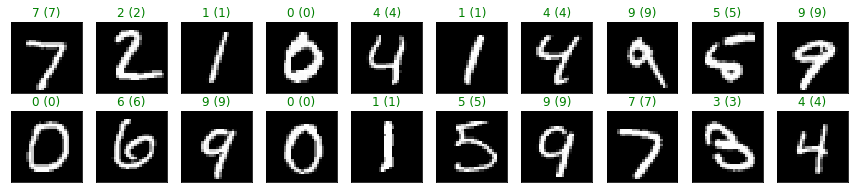

In [125]:
images, labels = next(iter(test_loader))

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))


## Keras

https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py

In [67]:
from tensorflow import keras
from tensorflow.keras import datasets, models, layers, optimizers
batch_size = 128
epochs = 50
imgsize = 28
patience = 2

### Load Data

In [68]:
(X_train, y_train), (X_test, y_test0) = datasets.mnist.load_data()
print(X_train.shape, y_train.shape)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)
X_train = X_train.astype('float32')/255  # normalize data from 0 to 1
X_test  = X_test.astype('float32') /255

y_train = keras.utils.to_categorical(y_train, 10) # convert class vectors to binary class matrices
y_test = keras.utils.to_categorical(y_test0, 10)

print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
(60000, 784) (60000, 10)


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


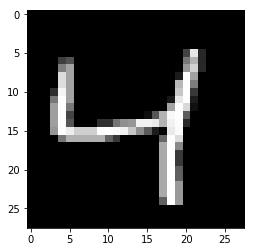

In [69]:
print(y_train[2])
plt.imshow(X_train[2].reshape(imgsize,imgsize), cmap='gray');

### Model

In [70]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],))) #can have init="glorot_normal",W_regularizer=l2(0.1)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax')) #or: relu,sigmoid, tanh
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Train

In [71]:
model.compile(loss='categorical_crossentropy', #or 'mse',
              optimizer=optimizers.RMSprop(),  #or 'SGD(lr,momentum,nesterov=True), RMSprop(), or 'sgd'...
              metrics=['accuracy'])            #metrics to show during fit

import tempfile
_,weightsfile=tempfile.mkstemp()
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
mc=ModelCheckpoint(weightsfile,monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

history = model.fit(X_train, y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1,callbacks=[es,mc],
                    validation_split=0.5) #or validation_data=(X_test, y_test)
model.load_weights(weightsfile)

Train on 30000 samples, validate on 30000 samples
Epoch 1/50
30000/30000 [==============================] - 2s 77us/sample - loss: 0.3285 - accuracy: 0.8986 - val_loss: 0.1545 - val_accuracy: 0.9529
Epoch 2/50
30000/30000 [==============================] - 2s 71us/sample - loss: 0.1316 - accuracy: 0.9602 - val_loss: 0.1472 - val_accuracy: 0.9559
Epoch 3/50
30000/30000 [==============================] - 2s 67us/sample - loss: 0.0902 - accuracy: 0.9715 - val_loss: 0.1270 - val_accuracy: 0.9636
Epoch 4/50
30000/30000 [==============================] - 2s 67us/sample - loss: 0.0694 - accuracy: 0.9784 - val_loss: 0.1116 - val_accuracy: 0.9685
Epoch 5/50
30000/30000 [==============================] - 2s 67us/sample - loss: 0.0512 - accuracy: 0.9836 - val_loss: 0.1097 - val_accuracy: 0.9730
Epoch 6/50
30000/30000 [==============================] - 2s 65us/sample - loss: 0.0413 - accuracy: 0.9858 - val_loss: 0.1160 - val_accuracy: 0.9727
Epoch 7/50
30000/30000 [==============================] 

In [72]:
history.history

{'loss': [0.32850160818099977,
  0.1315619120955467,
  0.0901821367541949,
  0.06938228738705317,
  0.051170790741220114,
  0.0413445831887424,
  0.037462397720913095,
  0.03076594284623861],
 'accuracy': [0.89856666,
  0.9601667,
  0.97153336,
  0.9783667,
  0.98356664,
  0.98576665,
  0.9874,
  0.9898],
 'val_loss': [0.15450996658404667,
  0.14719688108762105,
  0.12697286717096964,
  0.11160620767275492,
  0.10974602067271869,
  0.11596957130928834,
  0.13108660167058309,
  0.1261400809034705],
 'val_accuracy': [0.9528667,
  0.9558667,
  0.9636,
  0.9685,
  0.9730333,
  0.9726667,
  0.96903336,
  0.9737]}

### Evaluate

In [73]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_hat = model.predict_classes(X_test)
pd.crosstab(y_hat, y_test0)

Test score: 0.09277543093573767
Test accuracy: 0.9757


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,968,0,4,0,1,2,8,1,3,4
1,0,1124,0,0,0,0,3,4,0,4
2,1,4,1004,3,4,0,1,4,5,0
3,1,0,5,987,0,6,1,1,5,4
4,0,0,2,0,962,1,3,0,4,11
5,3,2,0,8,0,873,15,0,6,6
6,1,3,1,0,4,4,922,0,2,0
7,1,1,13,9,3,1,1,1016,8,11
8,3,1,3,2,2,3,4,1,937,5


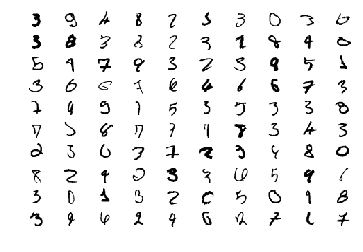

In [31]:
test_wrong = [im for im in zip(X_test,y_hat,y_test0) if im[1]!= im[2]]
for ind, val in enumerate(test_wrong[:100]):
    plt.subplot(10, 10, ind + 1)
    im = 1 - val[0].reshape((imgsize, imgsize))
    plt.axis("off")
    plt.imshow(im, cmap='gray')

weight matrix transposed: (512, 784)


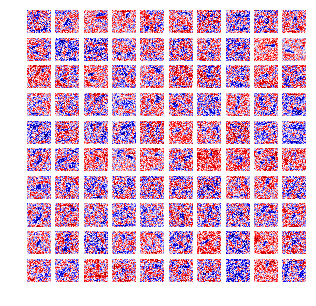

In [32]:
W1 = model.layers[0].get_weights()[0] # 0 for weights, 1 for bias
print("weight matrix transposed:",W1.T.shape)
plt.figure(figsize=(5, 5))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    im = W1.T[i].reshape((imgsize, imgsize,))
    plt.axis("off")
    plt.imshow(im, cmap='seismic')